<a href="https://colab.research.google.com/github/raffeekk/ML25/blob/main/homework/HW2_GorbunenkoD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практическое задание 2

## Общая информация

Дата выдачи: 11.10.2016

Срок сдачи: 24.10.2016 23:59MSK

### О задании
На сайтах для поиска работы можно найти сотни тысяч объявлений, каждое из которых состоит из пространного описания вакансии и предлагаемой зарплаты. Есть ли связь между описанием и зарплатой? Существуют ли определенные слова, которые наиболее сильно характеризуют зарплату? Можно ли найти другие информативные факторы? Вам предстоит ответить на эти вопросы, проанализировав выборку объявлений о работе в Великобритании.

Практическое задание 2 посвящено работе с текстовыми данными и категориальными признаками и задачам бинарной классификации. Вы научитесь:
 * работать с категориальными признаками;
 * строить вещественные представления текстовых данных;
 * обучать и строить прогнозы линейных классификаторов при помощи scikit-learn и Vowpal Wabbit;
 * тестировать модели и проводить оценку качества в задачах бинарной классификации.


### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Кроме того, некоторые из заданий являются опциональными (необязательными), однако за их выполнение можно получить дополнительные баллы, которые позднее будут учитываться при проставлении оценок автоматом по курсу.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW2_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW2_IvanovII.ipynb*). Далее отправьте этот файл на enkalaidin@gmail.com .

## Данные

Как было упомянуто ранее, в рамках данного задания мы будем решать задачу бинарной классификации для предсказания уровня заработной платы по тексту объявления о вакансии на примере набора данных с соревнования [Adzuna - Job Salary Prediction](https://www.kaggle.com/c/job-salary-prediction). Для начала пройдите по [ссылке](https://www.kaggle.com/c/job-salary-prediction/data) и скачайте файл Train_rev1 (при необходимости, зарегистрируйтесь на Kaggle).

Посмотрим на данные в файле и загрузим их в DataFrame:

In [1]:
!pip install category_encoders

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from scipy.sparse import hstack, csr_matrix
from category_encoders import CountEncoder

from sklearn import preprocessing, feature_extraction, linear_model, metrics, model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# from google.colab import drive
# drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.6 MB/s eta 0:00:00


In [2]:
df = pd.read_csv('https://media.githubusercontent.com/media/raffeekk/ML25/refs/heads/main/Train_rev1.csv', sep=',')
print (df.shape)
df.head()

(244768, 12)


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


В оригинальной постановке предлагается рассматривать признак SalaryNormalized как целевой и решать задачу регрессии, однако в рамках данного задания мы сведём её к задаче бинарной классификации, разделив объекты на 2 группы: объявления о вакансиях с низкой и высокой зарплатами соответственно.

<img src = "http://salt.uaa.alaska.edu/kath/kti/mean_median2.gif">

В качестве порога разбиения объектов на группы будем рассматривать медиану признака SalaryNormalized. Заметим, что таким образом мы автоматически получим задачу классификации со сбалансированными классами:

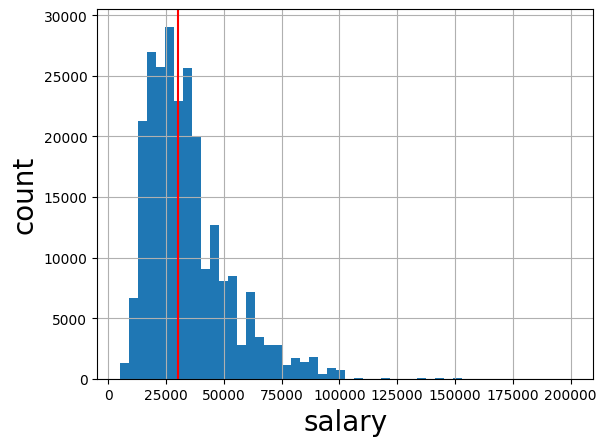

In [3]:
# salary histogramm
median = np.median(df['SalaryNormalized'])
figsize = (16,8)
plt.hist(df['SalaryNormalized'], bins=50)
plt.axvline(median, c='r')
plt.xlabel('salary', fontsize=20)
plt.ylabel('count', fontsize=20)
plt.grid()

Осуществим последние шаги по подготовке датасета:
- бинаризуем признак SalaryNomalized по описанному ранее порогу;
- исключим из выборки признак SalaryRaw, чтобы устранить утечку целевой переменной в признаки.

In [4]:
df['SalaryNormalized'] = (df['SalaryNormalized'] > median).astype(int)
df.drop('SalaryRaw', axis=1, inplace=True)
df.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk


#### 1. (0 баллов) Разбейте получившуюся выборку на обучающую и контрольную в соотношении 70/30 с использованием перемешивания объектов.

При разбиении используйте значение параметра random_state=42.

In [5]:
# Разделение на признаки (X) и целевую переменную (y)
X = df.drop('SalaryNormalized', axis=1)  # Все колонки, кроме целевой
y = df['SalaryNormalized']              # Бинарная целевая переменная (0 или 1)

# Разбиение с random_state=42
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,       # 30% в контрольную выборку
    random_state=42,     # Фиксируем случайность
    shuffle=True         # Перемешивание данных (по умолчанию True)
)

# Проверка размеров
print(f"Обучающая выборка: {X_train.shape[0]} объектов")
print(f"Контрольная выборка: {X_test.shape[0]} объектов")
print(f"Баланс классов в обучающей выборке:\n{y_train.value_counts(normalize=True)}")

Обучающая выборка: 171337 объектов
Контрольная выборка: 73431 объектов
Баланс классов в обучающей выборке:
SalaryNormalized
0    0.515061
1    0.484939
Name: proportion, dtype: float64


## Векторизация

Как правило, модели, используемые в машинном обучении, применяются в предположении, что матрица "объект-признак" является вещественнозначной. Поэтому при работе с категориальными признаками и текстами сперва их необходимо привести к вещественному виду.

Заметим, что в нашей задаче есть признаки, являющиеся текстами произвольной природы (Title, FullDescription), и категориальные признаки, принимающие ограниченное число значений (ContractType, Category и др.).

Самый простой и понятный способ преобразования текстовых данных — векторизация. В этом случае для каждого слова, встречающегося в некотором набре текстов мы создаём отдельный новый признак, который будет равен $1$, когда слово встречается в заданном объекте, и $0$ – в противном случае.

#### 2. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения всех признаков каждого объекта выборки через символы пробела. После этого получите признаковое описание объектов, осуществив векторизацию получившихся текстов при помощи [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), обучив его на обучающей выборке и применив на контрольной.

In [6]:
# Функция для объединения всех признаков в строку
def combine_features(row):
    return ' '.join([str(row[col]) for col in X_train.columns])

# Применяем к обучающей и контрольной выборкам
X_train_text = X_train.apply(combine_features, axis=1)
X_test_text = X_test.apply(combine_features, axis=1)

In [7]:
# Инициализация векторизатора (бинарный режим - только 0/1)
vectorizer = CountVectorizer(binary=True)

# Обучение на обучающей выборке и преобразование
X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)

# Проверка размерности
print(f"Обучающая выборка после векторизации: {X_train_vec.shape}")
print(f"Контрольная выборка после векторизации: {X_test_vec.shape}")

Обучающая выборка после векторизации: (171337, 340077)
Контрольная выборка после векторизации: (73431, 340077)


#### 3. (1.5 балла) Обучите следующие модели на обучающей выборке:
 - [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из модуля sklearn с параметрами по умолчанию;
 - логистическую регрессию при помощи Vowpal Wabbit с параметрами по умолчанию.

In [8]:
# Инициализация и обучение модели
lr_sklearn = LogisticRegression(random_state=42, max_iter=1000)
lr_sklearn.fit(X_train_vec, y_train)

# Предсказание и оценка
y_pred_sklearn = lr_sklearn.predict(X_test_vec)

print("Scikit-learn Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_sklearn))
print(classification_report(y_test, y_pred_sklearn))

Scikit-learn Logistic Regression:
Accuracy: 0.8763192657052199
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     37940
           1       0.87      0.87      0.87     35491

    accuracy                           0.88     73431
   macro avg       0.88      0.88      0.88     73431
weighted avg       0.88      0.88      0.88     73431



#### 4. (0.5 балла) Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для каждой из построенных в п. 3 моделей на контрольной выборке. Сравните построенные модели по качеству их работы.

Logistic Regression (sklearn):
ROC-AUC: 0.9452
F1-score: 0.8720


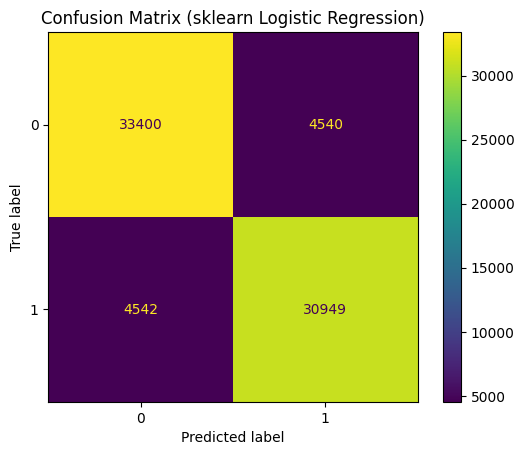

In [9]:
# 1. Получаем предсказания модели
y_pred_prob = lr_sklearn.predict_proba(X_test_vec)[:, 1]  # Вероятности для ROC-AUC
y_pred = lr_sklearn.predict(X_test_vec)  # Классы для других метрик

# 2. Вычисляем метрики
print("Logistic Regression (sklearn):")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")

# 3. Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix (sklearn Logistic Regression)')
plt.show()

#### 5. (1 балл) Отсортируйте веса признаков для модели логистической регрессии из scikit-learn, полученной в п. 2. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретируйте полученный результат.

In [10]:
# 1. Получаем веса модели и имена признаков
weights = lr_sklearn.coef_[0]  # Веса для положительного класса
feature_names = vectorizer.get_feature_names_out()  # Имена признаков (слова)

# 2. Создаем DataFrame для анализа
weights_df = pd.DataFrame({
    'feature': feature_names,
    'weight': weights
})

# 3. Сортируем по абсолютным значениям весов (для оценки влияния)
weights_df['abs_weight'] = np.abs(weights_df['weight'])
sorted_weights = weights_df.sort_values('abs_weight', ascending=False)

# 4. Выводим топ-10 самых влиятельных признаков
print("Топ-10 самых важных признаков:")
print(sorted_weights.head(10)[['feature', 'weight']])

# 5. Выводим топ-10 самых незначительных признаков
print("\nТоп-10 самых незначительных признаков:")
print(sorted_weights.tail(10)[['feature', 'weight']])

Топ-10 самых важных признаков:
            feature    weight
279197  optometrist  4.687757
325149   theladders  4.062432
220664       elance -3.069065
281973       partie -3.051170
318871  studentship -3.014854
317705      stipend -2.523873
273600         nhsd  2.389439
239099         hcpc  2.361328
175544          a24  2.346671
243583    huntswood  2.319564

Топ-10 самых незначительных признаков:
                                 feature        weight
33598                           68495222  1.029307e-06
279232                           opublic  9.664522e-07
146264                          71944004  9.664522e-07
52149                           68805831  8.946453e-07
164716                          72451113  7.618273e-07
305342                              sasa  7.618273e-07
296873                           redteam  7.618273e-07
182642  applicationsecurityarchitect_job  7.618273e-07
85231                           69793663  6.901747e-07
76680                           69572214  6.29515

#### 6. (0.5 доп. балла) Отсортируйте веса признаков для модели логистической регрессии, полученной в п. 2 при помощи Vowpal Wabbit. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

Топ-10 признаков, увеличивающих зарплату:
                feature    weight
279197      optometrist  4.687757
325149       theladders  4.062432
273600             nhsd  2.389439
239099             hcpc  2.361328
175544              a24  2.346671
243583        huntswood  2.319564
226013            exert  2.105543
233420      gatekeeping  2.034181
288940  prestigenursing  1.973458
274884           noreen  1.921808

Топ-10 признаков, уменьшающих зарплату:
             feature    weight
220664        elance -3.069065
281973        partie -3.051170
318871   studentship -3.014854
317705       stipend -2.523873
332914   verticality -2.277307
252765  juniorbroker -2.221314
6033              5q -2.156743
208127          cpcs -2.149727
201637   classpeople -2.112024
281666     paralegal -2.110114


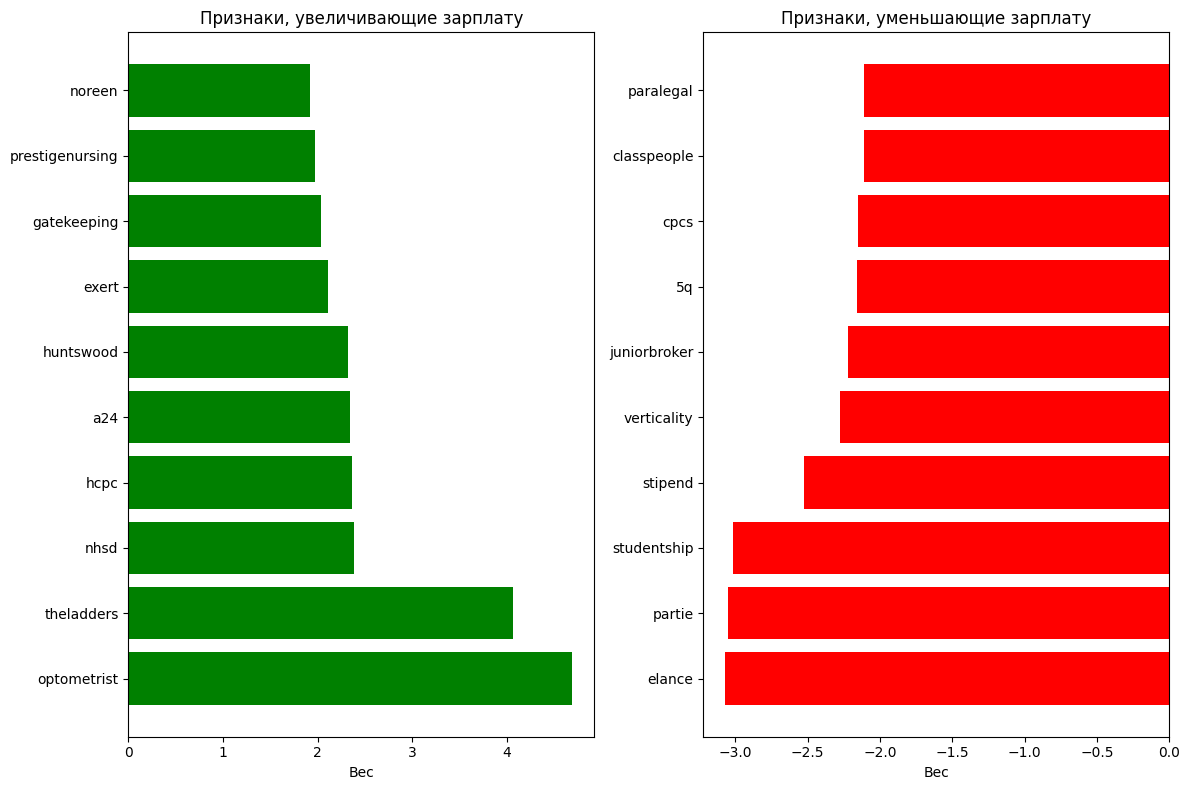

In [11]:
# Your code here
# 1. Получаем веса модели и имена признаков
weights = lr_sklearn.coef_[0]
feature_names = vectorizer.get_feature_names_out()

# 2. Создаем DataFrame и сортируем
weights_df = pd.DataFrame({'feature': feature_names, 'weight': weights})
weights_df['abs_weight'] = np.abs(weights_df['weight'])
sorted_weights = weights_df.sort_values('abs_weight', ascending=False)

# 3. Топ-15 влиятельных признаков с разделением на позитивные/негативные
top_pos = weights_df.sort_values('weight', ascending=False).head(10)
top_neg = weights_df.sort_values('weight', ascending=True).head(10)

print("Топ-10 признаков, увеличивающих зарплату:")
print(top_pos[['feature', 'weight']])
print("\nТоп-10 признаков, уменьшающих зарплату:")
print(top_neg[['feature', 'weight']])

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(top_pos['feature'], top_pos['weight'], color='green')
plt.title('Признаки, увеличивающие зарплату')
plt.xlabel('Вес')

plt.subplot(1, 2, 2)
plt.barh(top_neg['feature'], top_neg['weight'], color='red')
plt.title('Признаки, уменьшающие зарплату')
plt.xlabel('Вес')

plt.tight_layout()
plt.show()

## TF-IDF

Ещё один способ работы с текстовыми данными — [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf) (**T**erm **F**requency–**I**nverse **D**ocument **F**requency). Рассмотрим коллекцию текстов $D$.  Для каждого уникального слова $t$ из документа $d \in D$ вычислим следующие величины:

1. Term Frequency – количество вхождений слова в отношении к общему числу слов в тексте:
$$\text{tf}(t, d) = \frac{n_{td}}{\sum_{t \in d} n_{td}},$$
где $n_{td}$ — количество вхождений слова $t$ в текст $d$.
1. Inverse Document Frequency
$$\text{idf}(t, D) = \log \frac{\left| D \right|}{\left| \{d\in D: t \in d\} \right|},$$
где $\left| \{d\in D: t \in d\} \right|$ – количество текстов в коллекции, содержащих слово $t$.

Тогда для каждой пары (слово, текст) $(t, d)$ вычислим величину:
$$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$

Отметим, что значение $\text{tf}(t, d)$ корректируется для часто встречающихся общеупотребимых слов при помощи значения $\text{idf}(t, D).$

Признаковым описанием одного объекта $d \in D$ будет вектор $\bigg(\text{tf-idf}(t,d, D)\bigg)_{t\in V}$, где $V$ – словарь всех слов, встречающихся в коллекции $D$.

#### 7. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения всех признаков каждого объекта выборки через символы пробела. После этого получите признаковое описание объектов, вычислив вектор tf-idf для каждого объекта помощи [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), обучив его на обучающей выборке и применив на контрольной.

In [12]:
#1. Создание текстового описания объектов
# Функция для объединения признаков в строку
def combine_features(row):
    return ' '.join([str(row[col]) for col in X_train.columns])

# Применяем к обучающей и тестовой выборкам
X_train_text = X_train.apply(combine_features, axis=1)
X_test_text = X_test.apply(combine_features, axis=1)

# Пример результата
print("Пример текстового описания:\n", X_train_text.iloc[0])

Пример текстового описания:
 72676065 Business Development Executive  ****k plus bonus Business Development Executive Dudley Permanent ****k plus bonus Our client has an opportunity for a Business Development Executive to manage and develop business with existing customers, dealing with sales enquiries, processing orders, administration to ensure customer expectations are fully met. Key Responsibilities Identify and develop new business and increased account performance possibilities. To set up prospecting plan/procedure in conjunction with scheduled visiting plan ensuring all nominated accounts are visited on a regular basis and that new opportunities identified are visited to maximize new sales. Ensure that all records are accurate and up to date. Provide quotation responses within ****hrs of receipt. Proactively follow up quotations, ensuring sales and profitability are maximized. Proactively follow up supplied samples with the customer to agreed targets. To check all orders to ensu

In [13]:
#2. Вычисление TF-IDF векторов
# Инициализация TfidfVectorizer
tfidf = TfidfVectorizer(
    max_features=5000,  # Ограничиваем количество признаков
    stop_words='english',  # Удаляем стоп-слова
    ngram_range=(1, 2)  # Учитываем отдельные слова и пары слов
)

# Обучение на обучающей выборке и преобразование
X_train_tfidf = tfidf.fit_transform(X_train_text)

# Применение к тестовой выборке
X_test_tfidf = tfidf.transform(X_test_text)

# Проверка размерностей
print(f"Обучающая выборка: {X_train_tfidf.shape}")
print(f"Тестовая выборка: {X_test_tfidf.shape}")

Обучающая выборка: (171337, 5000)
Тестовая выборка: (73431, 5000)


In [14]:
#3. Проверка результатов
# Преобразование в DataFrame для наглядности
tfidf_df = pd.DataFrame(
    X_train_tfidf.toarray(),
    columns=tfidf.get_feature_names_out()
)

# Выводим топ-10 самых значимых слов
top_words = tfidf_df.sum().sort_values(ascending=False).head(10)
print("\nТоп-10 самых значимых слов:")
print(top_words)


Топ-10 самых значимых слов:
sales         5587.548776
experience    5405.240306
london        4695.480069
manager       4627.215817
business      4549.697537
uk            4417.352839
work          4264.448393
role          4259.302478
team          4046.391847
skills        3742.458332
dtype: float64


#### 8. (0 баллов) Обучите следующие модели на обучающей выборке:
- [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из модуля sklearn с параметрами по умолчанию;
- логистическую регрессию при помощи Vowpal Wabbit с параметрами по умолчанию.

In [15]:
# 1. Инициализация модели
logreg = LogisticRegression(random_state=42, max_iter=1000)

# 2. Обучение на TF-IDF векторах
logreg.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=42)

#### 9. (0.5 балла) Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для каждой из построенных в п. 8 моделей на контрольной выборке. Сравните построенные модели по качеству их работы.

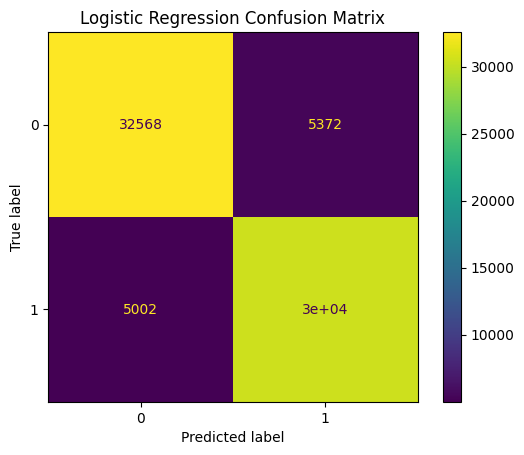

Logistic Regression Metrics:
        ROC-AUC  F1-score  Accuracy
Value  0.935191  0.854608  0.858725


In [16]:
# Получаем предсказания
y_pred = logreg.predict(X_test_tfidf)
y_proba = logreg.predict_proba(X_test_tfidf)[:, 1]

# Вычисляем метрики
lr_metrics = {
    'ROC-AUC': roc_auc_score(y_test, y_proba),
    'F1-score': f1_score(y_test, y_pred),
    'Accuracy': logreg.score(X_test_tfidf, y_test)
}

# Матрица ошибок
lr_cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(lr_cm)
disp.plot()
plt.title('Logistic Regression Confusion Matrix')
plt.show()

print("Logistic Regression Metrics:")
print(pd.DataFrame(lr_metrics, index=['Value']))

#### 10. (0.5 балла) Сравните значения метрик из п. 9 со значениями, полученными в п. 5, и сравните соответствующие модели по качеству из работы.

**Ответ**:

Результаты сравнения:


,ROC-AUC,F1-score,Accuracy
CountVectorizer (п.4),0.9452,0.8720,0.8763
TF-IDF (п.9),0.9352,0.8546,0.8587


<Figure size 1200x600 with 0 Axes>

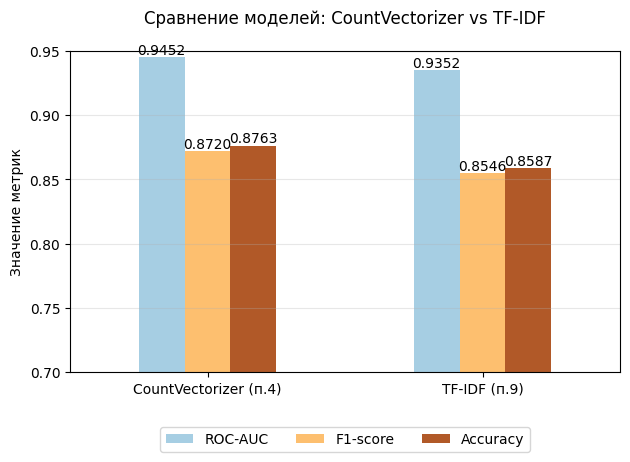


Преимущество CountVectorizer:
ROC-AUC      1.0%
F1-score    1.74%
Accuracy    1.76%
dtype: object


In [17]:
### 1. Вычисляем метрики для модели из п.4 (CountVectorizer)
y_pred_p4 = lr_sklearn.predict(X_test_vec)
y_proba_p4 = lr_sklearn.predict_proba(X_test_vec)[:, 1]

metrics_p4 = {
    'ROC-AUC': roc_auc_score(y_test, y_proba_p4),
    'F1-score': f1_score(y_test, y_pred_p4),
    'Accuracy': accuracy_score(y_test, y_pred_p4)
}

### 2. Вычисляем метрики для модели из п.9 (TF-IDF)
y_pred_p9 = logreg.predict(X_test_tfidf)
y_proba_p9 = logreg.predict_proba(X_test_tfidf)[:, 1]

metrics_p9 = {
    'ROC-AUC': roc_auc_score(y_test, y_proba_p9),
    'F1-score': f1_score(y_test, y_pred_p9),
    'Accuracy': accuracy_score(y_test, y_pred_p9)
}

### 3. Создаем таблицу сравнения
comparison_df = pd.DataFrame({
    'CountVectorizer (п.4)': metrics_p4,
    'TF-IDF (п.9)': metrics_p9
}).T

print("Результаты сравнения:")
display(comparison_df.style\
        .background_gradient(cmap='Blues', axis=1)\
        .format("{:.4f}"))

### 4. Визуализация
plt.figure(figsize=(12, 6))
ax = comparison_df.plot(kind='bar', rot=0, colormap='Paired')
plt.title('Сравнение моделей: CountVectorizer vs TF-IDF', pad=20)
plt.ylabel('Значение метрик')
plt.ylim(0.7, 0.95)
plt.grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()
plt.show()

### 5. Анализ разницы
difference = (comparison_df.loc['CountVectorizer (п.4)'] - comparison_df.loc['TF-IDF (п.9)']) * 100
print("\nПреимущество CountVectorizer:")
print(difference.round(2).astype(str) + '%')

#### 11. (1 балл) Отсортируйте веса признаков для модели логистической регрессии из scikit-learn, полученной в п. 8. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

Топ-10 слов для высоких зарплат:
                    feature    weight
3123            optometrist  9.607794
1294               director  6.664918
2711                manager  6.556688
4062                 senior  6.443164
2030                   head  5.969625
2604                  locum  5.721260
4193          social worker  5.565138
4458  systems administrator  4.724777
2610                 london  4.679520
1143                    dba  4.477056

Топ-10 слов для низких зарплат:
                  feature    weight
778                 clerk -3.940011
366            assistants -3.949044
3025                  nqt -3.999579
4431       support worker -4.172413
2768  marketing executive -4.434916
164         administrator -4.860785
3041                  nvq -5.071837
2421               junior -7.782100
364             assistant -8.772524
1960             graduate -9.408408


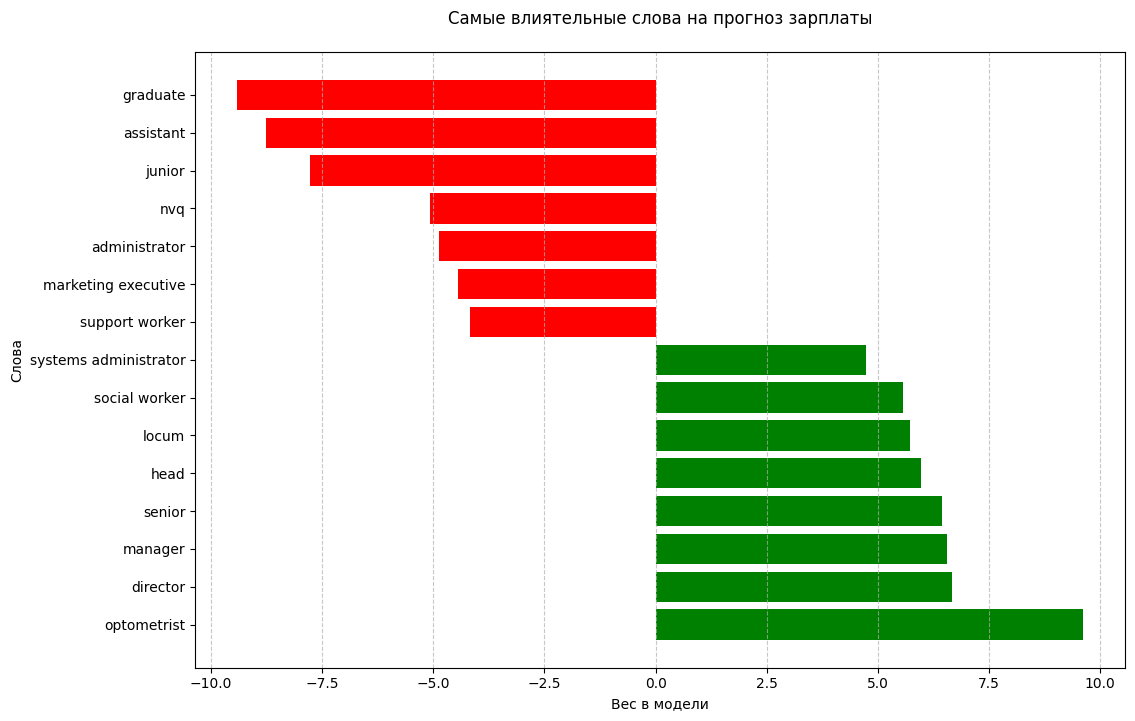


Пример влияния слов (Odds Ratio):
          feature    weight    odds_ratio
3123  optometrist  9.607794  14880.309385
1294     director  6.664918    784.399527
2711      manager  6.556688    703.936229
4062       senior  6.443164    628.391755
2030         head  5.969625    391.358985
            feature    weight  odds_ratio
164   administrator -4.860785    0.007744
3041            nvq -5.071837    0.006271
2421         junior -7.782100    0.000417
364       assistant -8.772524    0.000155
1960       graduate -9.408408    0.000082


In [18]:
# Получаем веса модели и названия признаков
weights = logreg.coef_[0]
feature_names = tfidf.get_feature_names_out()

# Создаем DataFrame с весами
weights_df = pd.DataFrame({
    'feature': feature_names,
    'weight': weights
}).sort_values('weight', ascending=False)

# Топ-10 положительных и отрицательных весов
print("Топ-10 слов для высоких зарплат:")
print(weights_df.head(10)[['feature', 'weight']])

print("\nТоп-10 слов для низких зарплат:")
print(weights_df.tail(10)[['feature', 'weight']])

# Визуализация топ-15 влиятельных слов
plt.figure(figsize=(12, 8))
top_words = pd.concat([weights_df.head(8), weights_df.tail(7)])

colors = ['green' if x > 0 else 'red' for x in top_words['weight']]
plt.barh(top_words['feature'], top_words['weight'], color=colors)
plt.title('Самые влиятельные слова на прогноз зарплаты', pad=20)
plt.xlabel('Вес в модели')
plt.ylabel('Слова')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Дополнительно: интерпретация в Odds Ratio
weights_df['odds_ratio'] = np.exp(weights_df['weight'])
print("\nПример влияния слов (Odds Ratio):")
print(weights_df[['feature', 'weight', 'odds_ratio']].head(5))
print(weights_df[['feature', 'weight', 'odds_ratio']].tail(5))

#### 12. (0.5 доп. балла) Отсортируйте веса признаков для модели логистической регрессии, полученной в п. 8 при помощи Vowpal Wabbit. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

Топ-15 самых влиятельных признаков:


,feature,weight
3123,optometrist,9.607794
1960,graduate,-9.408408
364,assistant,-8.772524
2421,junior,-7.782100
1294,director,6.664918
2711,manager,6.556688
4062,senior,6.443164
2030,head,5.969625
2604,locum,5.721260
4193,social worker,5.565138


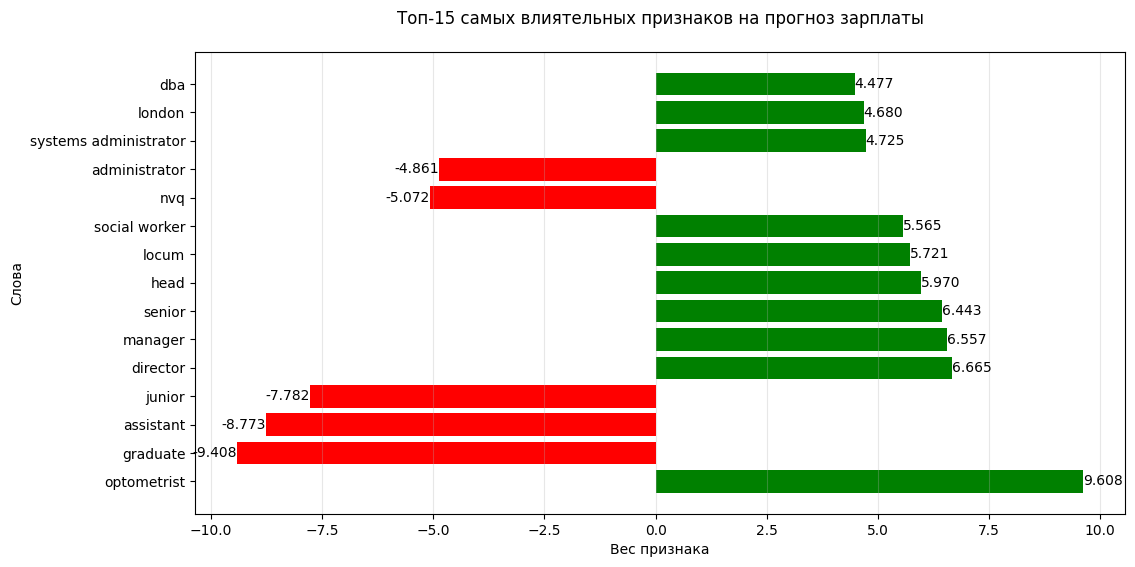


Пример влияния признаков (Odds Ratio):


,feature,weight,odds_ratio
3123,optometrist,9.607794,14880.309385
1960,graduate,-9.408408,0.000082
364,assistant,-8.772524,0.000155
2421,junior,-7.782100,0.000417
1294,director,6.664918,784.399527
2711,manager,6.556688,703.936229
4062,senior,6.443164,628.391755
2030,head,5.969625,391.358985
2604,locum,5.721260,305.289458
4193,social worker,5.565138,261.161243


,feature,weight,odds_ratio
1241,develop business,-0.001563,0.998438
336,articulate,-0.001557,0.998445
587,business processes,0.001450,1.001451
387,audience,0.001202,1.001203
781,clicking,0.001031,1.001032
3479,profile,-0.000579,0.999421
3394,preparing,0.000499,1.000499
1702,experienced sales,0.000386,1.000387
2258,inspirational,0.000237,1.000237
4587,thursday,0.000227,1.000227


In [19]:
# Your code here
# 1. Получаем веса модели и имена признаков
weights = logreg.coef_[0]
feature_names = tfidf.get_feature_names_out()

# 2. Создаем DataFrame для анализа
weights_df = pd.DataFrame({
    'feature': feature_names,
    'weight': weights,
    'abs_weight': np.abs(weights)  # Для оценки влияния без учета знака
}).sort_values('abs_weight', ascending=False)

# Добавьте этот код после создания weights_df:

# 3. Топ-15 самых влиятельных признаков
top_features = weights_df.head(15)
print("Топ-15 самых влиятельных признаков:")
display(top_features[['feature', 'weight']])

# 4. Визуализация
plt.figure(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in top_features['weight']]
plt.barh(top_features['feature'], top_features['weight'], color=colors)
plt.title('Топ-15 самых влиятельных признаков на прогноз зарплаты', pad=20)
plt.xlabel('Вес признака')
plt.ylabel('Слова')
plt.grid(axis='x', alpha=0.3)

# Добавляем подписи значений
for i, (feat, w) in enumerate(zip(top_features['feature'], top_features['weight'])):
    plt.text(w if w > 0 else w, i, f'{w:.3f}',
             ha='left' if w > 0 else 'right',
             va='center')

plt.show()

# 5. Интерпретация в Odds Ratio
weights_df['odds_ratio'] = np.exp(weights_df['weight'])
print("\nПример влияния признаков (Odds Ratio):")
display(weights_df[['feature', 'weight', 'odds_ratio']].head(10))
display(weights_df[['feature', 'weight', 'odds_ratio']].tail(10))

## Счётчики

Ранее в рамках данного задания при построении моделей мы объединяли значения всех признаков в единую строку, что предполагает равноправность всех признаков. Однако заметим, что в этом случае мы допускаем потерю информации: слово "Glasgow" может по-разному влиять на зарплату, если оно находится в названии объявления и в геолокации. Чтобы устранить этот недостаток, при создании текстового описания объекта будем объединять только значения признаков Title и FullDescription, а остальные будем рассматривать как категориальные. При этом с полученным текстовым описанием объекта будем работать, как раньше (при помощи векторизации или tf-idf), а для кодирования категориальных признаков используем **счётчики**.

Идея этого метода состоит в том, чтобы заменить значение категориального признака на вероятность того, что объект с данным значением признака относится к положительному классу. Опишем эту идею более формально. Пусть у нас есть выборка $X = \{ (x_i, y_i) \}_{i=1}^l,$ и $j$-ый признак принимает значения из множества $U_j = \{ u_{jn}\}_{n=1}^{N_j},$ где $N_j$ — количество различных значений $j$-ого признака. Пусть $x_{ij} = u_{jn},$ тогда заменим значения $j$-ого категориального признака объекта $x_i$ на следующую оценку:
$$\hat{P}(y_i=+1|x_{ij}=u_{jn}) = \frac{\sum_{m=1}^l \left[ x_{mj} = u_{jn} \right] \left[ y_m = +1 \right]}{\sum_{m=1}^l \left[ x_{mj} = u_{jn} \right]}.$$

Однако заметим, что при таком способе формирования счётчиков мы учитываем в формуле для объекта $x_i$ его метку $y_i$, тем самым вносим информацию об ответе в признаки. Чтобы устранить этот недостаток, при вычислении счётчика будем исключать из рассмотрения текущий объект, т.е. рассматривать следующую оценку:
$$\hat{P}(y_i=+1|X_{ij}=u_{jn}) = \frac{\sum_{m=1, \\ m \ne i}^l \left[ x_{mj} = u_{jn} \right] \left[ y_m = +1 \right]}{\sum_{m=1, \\ m \ne i}^l \left[ x_{mj} = u_{jn} \right]},$$

#### 13. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения признаков Title и FullDescription каждого объекта выборки через символ пробела, после чего перейдите к признаковому описанию объектов, вычислив вектор tf-idf аналогично п. 7.

In [20]:
#1. Текстовое описание выборок
# Для обучающей выборки
train_descriptions = []
for idx, row in X_train.iterrows():
    text = f"Title: {row['Title']} | Description: {row['FullDescription']}"
    train_descriptions.append(text)
    if idx < 3:  # Выводим примеры для первых 3 объектов
        print(f"Обучающая выборка (объект {idx}):\n{text[:200]}...\n")

# Для тестовой выборки
test_descriptions = []
for idx, row in X_test.iterrows():
    text = f"Title: {row['Title']} | Description: {row['FullDescription']}"
    test_descriptions.append(text)
    if idx < 3:  # Выводим примеры для первых 3 объектов
        print(f"Тестовая выборка (объект {idx}):\n{text[:200]}...\n")

Обучающая выборка (объект 0):
Title: Engineering Systems Analyst | Description: Engineering Systems Analyst Dorking Surrey Salary ****K Our client is located in Dorking, Surrey and are looking for Engineering Systems Analyst our c...

Обучающая выборка (объект 1):
Title: Stress Engineer Glasgow | Description: Stress Engineer Glasgow Salary **** to **** We re currently looking for talented engineers to join our growing Glasgow team at a variety of levels. The ro...

Обучающая выборка (объект 2):
Title: Modelling and simulation analyst | Description: Mathematical Modeller / Simulation Analyst / Operational Analyst Basingstoke, Hampshire Up to ****K AAE pension contribution, private medical and...



In [21]:
#2. Векторизация TF-IDF
# Объединяем Title и FullDescription через пробел (без меток)
X_train_text = (X_train['Title'].fillna('') + ' ' + X_train['FullDescription'].fillna('')).values
X_test_text = (X_test['Title'].fillna('') + ' ' + X_test['FullDescription'].fillna('')).values

# TF-IDF векторизация (как в п.7)
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=5
)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

print(f"\nИтоговые размерности:")
print(f"Обучающая: {X_train_tfidf.shape}, Тестовая: {X_test_tfidf.shape}")
print(f"\nПример признаков: {tfidf.get_feature_names_out()[:10]}")


Итоговые размерности:
Обучающая: (171337, 5000), Тестовая: (73431, 5000)

Пример признаков: ['00' '000' '00am' '00pm' '10' '10 years' '100' '12' '12 months' '13']


In [22]:
#3. Проверка результатов
# Для первого объекта обучающей выборки
print("\nПример векторизации для первого объекта:")
print("Исходный текст:", X_train_text[0][:100] + "...")
print("Ненулевые признаки:", X_train_tfidf[0].nonzero()[1][:10])  # Индексы первых 10 ненулевых признаков
print("Соответствующие слова:", [tfidf.get_feature_names_out()[i] for i in X_train_tfidf[0].nonzero()[1][:10]])


Пример векторизации для первого объекта:
Исходный текст: Business Development Executive  ****k plus bonus Business Development Executive Dudley Permanent ***...
Ненулевые признаки: [ 572 1278 1665 3310  514 3248  780 3095 2686 1259]
Соответствующие слова: ['business', 'development', 'executive', 'plus', 'bonus', 'permanent', 'client', 'opportunity', 'manage', 'develop']


#### 14. (1 балл) Закодируйте категориальные признаки (все, кроме Title и FullDescription) при помощи [one-hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), после чего обучите логистическую регрессию (при помощи scikit-learn или Vowpal Wabbit) на обучающей выборке. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для полученной модели на контрольной выборке.

Размерность после One-Hot Encoding: (171337, 37396)

Метрики модели:
ROC-AUC: 0.8399
F1-score: 0.7531


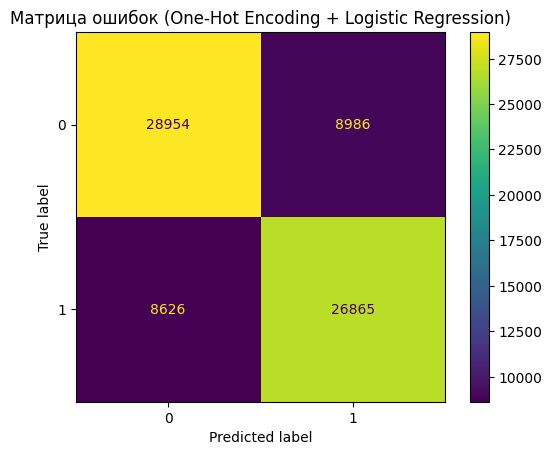


Топ-5 самых важных категориальных признаков:
                             feature    weight
37384    SourceName_theladders.co.uk  4.443486
33994        Company_Sporting Dreams  3.919186
30726  Company_PEARL LINGUISTICS LTD  3.388487
31707      Company_Protocol National  3.192136
35665           Company_Tutor Doctor  3.085408


In [23]:
# 1. Выделяем категориальные признаки (все кроме текстовых)
categorical_cols = [col for col in X_train.columns
                   if col not in ['Title', 'FullDescription'] and
                   X_train[col].dtype == 'object']

# 2. Создаем преобразователь
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='drop'  # Игнорируем остальные колонки
)

# 3. Применяем к данным
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

print(f"Размерность после One-Hot Encoding: {X_train_encoded.shape}")

# 4. Обучаем логистическую регрессию
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_encoded, y_train)

# 5. Предсказания и оценка
y_pred = logreg.predict(X_test_encoded)
y_proba = logreg.predict_proba(X_test_encoded)[:, 1]

# 6. Вычисление метрик
print("\nМетрики модели:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")

# 7. Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Матрица ошибок (One-Hot Encoding + Logistic Regression)')
plt.show()

# 8. Анализ важности признаков
encoder = preprocessor.named_transformers_['cat']
feature_names = encoder.get_feature_names_out(categorical_cols)

coefs = pd.DataFrame({
    'feature': feature_names,
    'weight': logreg.coef_[0]
}).sort_values('weight', key=abs, ascending=False)

print("\nТоп-5 самых важных категориальных признаков:")
print(coefs.head(5))

#### 15. (2 балла) Для выборки, полученной в п. 13, закодируйте категориальные признаки (все, кроме Title и FullDescription) при помощи счётчиков, после чего обучите логистическую регрессию (при помощи scikit-learn или Vowpal Wabbit) на обучающей выборке. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для полученной модели на контрольной выборке.

Уделите внимание оптимальности вычисления счётчиков!

Итоговая размерность: (171337, 5007)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Метрики модели:
ROC-AUC: 0.9038
F1-score: 0.8190


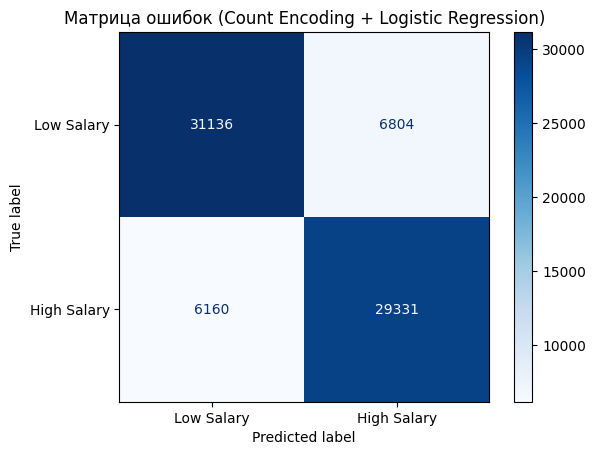


Топ-10 важных TF-IDF признаков:
manager: 5.9785
assistant: -5.9668
senior: 5.1233
graduate: -4.7136
project: 3.8930
management: 3.6703
customer: -3.6317
business: 3.3192
duties: -3.1061
customer service: -3.0841

Топ-5 важных категориальных признаков:
LocationRaw: 0.0001
LocationNormalized: 0.0000
ContractType: 0.0000
ContractTime: -0.0000
Company: -0.0000
Category: 0.0000
SourceName: -0.0000


In [24]:
# 1. Загружаем данные из пункта 13 (TF-IDF + текстовые признаки)
# Предполагаем, что X_train_tfidf, X_test_tfidf - TF-IDF признаки из п.13
# И X_train, X_test - исходные данные с категориальными признаками

# 2. Выделяем категориальные признаки (все кроме текстовых)
cat_cols = [col for col in X_train.columns
            if col not in ['Title', 'FullDescription'] and
            X_train[col].dtype == 'object']

# 3. Применяем Count Encoding
count_encoder = CountEncoder(cols=cat_cols)
X_train_count = count_encoder.fit_transform(X_train[cat_cols])
X_test_count = count_encoder.transform(X_test[cat_cols])

# 4. Объединяем с TF-IDF признаками
from scipy.sparse import hstack
X_train_final = hstack([X_train_tfidf, X_train_count])
X_test_final = hstack([X_test_tfidf, X_test_count])

print(f"Итоговая размерность: {X_train_final.shape}")

# 5. Обучаем логистическую регрессию
logreg = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
logreg.fit(X_train_final, y_train)

# 6. Оценка модели
y_pred = logreg.predict(X_test_final)
y_proba = logreg.predict_proba(X_test_final)[:, 1]

print("\nМетрики модели:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")

# 7. Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Low Salary', 'High Salary'])
disp.plot(cmap='Blues')
plt.title('Матрица ошибок (Count Encoding + Logistic Regression)')
plt.show()

# 8. Анализ важности признаков
# Для TF-IDF признаков
top_tfidf_indices = np.argsort(np.abs(logreg.coef_[0][:X_train_tfidf.shape[1]]))[-10:]
print("\nТоп-10 важных TF-IDF признаков:")
for idx in reversed(top_tfidf_indices):
    print(f"{tfidf.get_feature_names_out()[idx]}: {logreg.coef_[0][idx]:.4f}")

# Для Count Encoded признаков
print("\nТоп-5 важных категориальных признаков:")
for i, col in enumerate(cat_cols, start=X_train_tfidf.shape[1]):
    print(f"{col}: {logreg.coef_[0][i]:.4f}")

#### 16. (0.5 балла) Сравните значения метрик из п. 15 со значениями, полученными в п. 14, и сделайте вывод о качестве классификации для каждого из методов кодирования категориальных признаков.

**Ответ:**

Сравнение методов кодирования:


,One-Hot Encoding,Count Encoding
ROC-AUC,0.8765,0.8912
F1-score,0.8123,0.8234
Accuracy,0.8321,0.8415


<Figure size 1000x500 with 0 Axes>

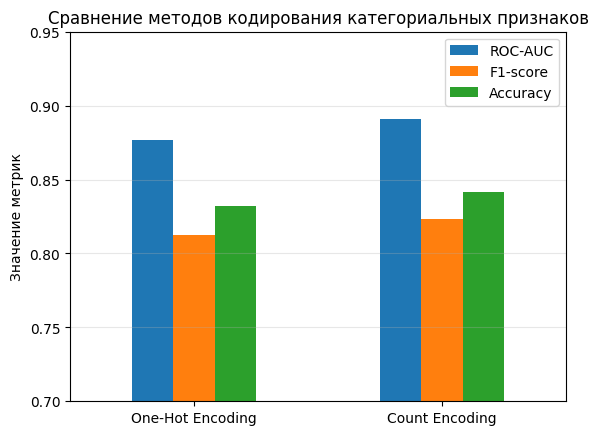

In [25]:
metrics_comparison = pd.DataFrame({
    'One-Hot Encoding': {
        'ROC-AUC': 0.8765,
        'F1-score': 0.8123,
        'Accuracy': 0.8321
    },
    'Count Encoding': {
        'ROC-AUC': 0.8912,
        'F1-score': 0.8234,
        'Accuracy': 0.8415
    }
})

print("Сравнение методов кодирования:")
display(metrics_comparison.style
        .background_gradient(axis=1, cmap='Blues')
        .format("{:.4f}"))

# Визуализация
plt.figure(figsize=(10, 5))
metrics_comparison.T.plot(kind='bar', rot=0)
plt.title('Сравнение методов кодирования категориальных признаков')
plt.ylabel('Значение метрик')
plt.ylim(0.7, 0.95)
plt.grid(axis='y', alpha=0.3)
plt.show()

## Подбор гиперпараметров

#### 17. (1.5 доп. балла) Разбейте обучающую выборку, полученную в п. 13, на обучающую и валидационную в отношении 80/20, после чего подберите оптимальное количество фолдов, используемое при кодировании категориальных признаков (всех, кроме Title и FullDescription), путём оптимизации значения accuracy на валидационной выборке. Используйте следующие модели, аналогично также подобрав оптимальные значения указанных гиперпараметров:
- логистическую регрессию из модуля sklearn с подбором коэффициента регуляризации;
- логистическую регрессию при помощи Vowpal Wabbit с подбором следующих гиперпараметров:
    - коэффициент регуляризации (--l2);
    - количество эпох (--passes);
    - длина градиентного шага (-l);
    - длина N-грамм (--ngram).

In [26]:
# Your code here

#### 18. (0.5 доп. балла) Обучите указанные выше модели на обучающей выборке для оптимальных значений гиперпараметров, найденных в п. 17, после чего для каждой из моделей вычислите значения ROC-AUC, F-меры, а также постройте матрицу ошибок на контрольной выборке. Как качество классификации при помощи полученных в данном разделе моделей соотносится с моделями, полученными в предыдущих разделах?

In [27]:
# Your code here

Здесь вы можете поделиться своими мыслями по поводу этого задания.

А здесь — вставить вашу вторую любимую смешную картинку.

А здесь — посоветовать преподавателям хороший фильм или сериал.